
- Author: Naustone
- Purpose: LTSM
- Date: Jun-01-2018
- Python: 3.6.5


# Overview of Machine Learning


### Agenda

- confluence pages
- new trends of machine learning
- terminology
- taximony of machine learning
- utilize pre-trained models

 ## 1 New Trends of Machine Learning
 
 - Data availability.

 - Computational scale
 

<img src=models.png>

Sourced from <b>machine learning yearning"</b>
http://www.mlyearning.org/    
    


<i>

This diagram shows NNs doing better in the regime of small datasets. This effect is less consistent
than the effect of NNs doing well in the regime of huge datasets. In the small data regime, depending
on how the features are hand-engineered, traditional algorithms may or may not do better. For
example, if you have 20 training examples, it might not matter much whether you use logistic
regression or a neural network; the hand-engineering of features will have a bigger effect than the
choice of algorithm. But if you have 1 million examples, I would favor the neural network.

--- by Andrew Ng</i>

 - Ensemble models achieve good performance comparing to single strong models.
 
 <img src="random_forest.png">

# 2 Terminology

- features
- training set: Which you run your learning algorithm
- validation set: on which you turn parameters and select features
- test set 

<Note> Your validation and test sets should come from the same distribution



##### can you name some features for stock return prediction?

## 3 Machine Learning Algorithms

<img src='scikit-learn.png'>

In [1]:
import matplotlib

from __future__ import print_function
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint

from keras.models import Sequential
from keras.layers import LSTM,Dense,GRU
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm

Using TensorFlow backend.


### 3.1 time series analysis

Predict value of a stationery process based on its lagged value and lagged error  


#### 3.1.1 load data from external file

In [2]:
import pandas as pd
import numpy as np

raw = pd.read_csv("EUR_JPY.csv")
aapl = raw.copy()
aapl['time']=pd.to_datetime(aapl['time'])

In [3]:
aapl.head(10)

,time,high,low,close,open
0,2018-05-23 06:38:00,129.799,129.772,129.790,129.792
1,2018-05-23 06:39:00,129.796,129.756,129.756,129.794
2,2018-05-23 06:40:00,129.760,129.722,129.722,129.760
3,2018-05-23 06:41:00,129.753,129.726,129.753,129.726
4,2018-05-23 06:42:00,129.765,129.748,129.748,129.756
5,2018-05-23 06:43:00,129.752,129.744,129.751,129.751
6,2018-05-23 06:44:00,129.786,129.748,129.786,129.748
7,2018-05-23 06:45:00,129.786,129.768,129.768,129.782
8,2018-05-23 06:46:00,129.792,129.761,129.788,129.772
9,2018-05-23 06:47:00,129.818,129.792,129.797,129.792


#### 3.1.2 preprocessing data and feature engineering

First I need to make target variable stationary, meaning costant statistics through time. Obviously, close price of AAPL trends up. To make it stationary, I will take log return of close price. Therefore, mean and variance for log return distribution keeps constant over time.

In [4]:
aapl['prev_close'] = aapl['close'].shift()
aapl['logret'] = aapl.apply(lambda x:np.log(x['close']/x['prev_close']),axis=1)
                            
#aapl['prev_volume']= aapl['volume'].shift()
#aapl['logvolume'] = aapl.apply(lambda x:np.log(x['volume']/x['prev_volume']),axis=1)

#### What else we can make out of close price? any other momentum factors?

In [5]:
aapl['daily_var'] = aapl['high']-aapl['low']
#aapl['ln_daily_var'] = np.log(aapl['daily_var'])
aapl['prev_daily_var'] = aapl['daily_var'].shift()
aapl['logret_1w_ago']=aapl['logret'].shift(5)
aapl['logret_1M_ago']=aapl['logret'].shift(22)
aapl['logret_3M_ago']=aapl['logret'].shift(66)
aapl['dlogret']=aapl['logret']- aapl['logret'].shift()

In [6]:
def plot_price_return(df):
    # Graph data
    #aapl.set_index('date',inplace=True)
    fig, axes = plt.subplots(1, 2, figsize=(15,4))

    # Levels
    axes[0].plot(df.index._mpl_repr(), df['close'], '-')
    axes[0].set(title='AAPL closing price')

    # Log difference
    axes[1].plot(df.index._mpl_repr(), df['dlogret'], '-')
    axes[1].set(title='AAPL differece of log return');

There are clear trends in close price but the log return shows strong mean-reverting pattern.

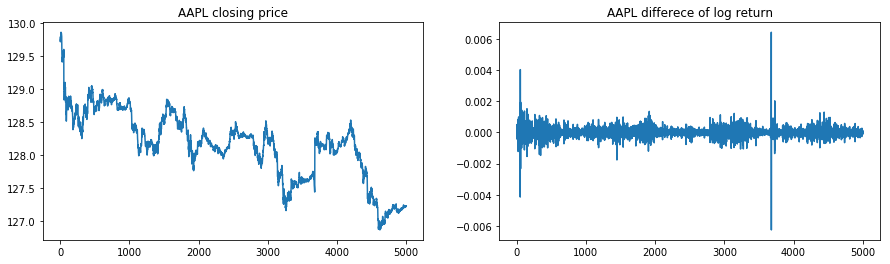

In [7]:
plot_price_return(aapl)

In [8]:
#training['ln_daily_var'].plot()
aapl.set_index('time',inplace=True)

#### 3.1.3 setup training set, development set and test set

In [9]:
training = aapl[aapl.index<'2018-05-25 05:27:00']
dev= aapl[(aapl.index>='2018-05-25 05:27:00') & (aapl.index<'2018-05-27 22:38:00')]
test = aapl[(aapl.index>='2018-05-27 22:38:00')]
training = training.reset_index()
dev = dev.reset_index()
test = test.reset_index()

print (training,test,dev)

                    time     high      low    close     open  prev_close  \
0    2018-05-23 06:38:00  129.799  129.772  129.790  129.792         NaN   
1    2018-05-23 06:39:00  129.796  129.756  129.756  129.794     129.790   
2    2018-05-23 06:40:00  129.760  129.722  129.722  129.760     129.756   
3    2018-05-23 06:41:00  129.753  129.726  129.753  129.726     129.722   
4    2018-05-23 06:42:00  129.765  129.748  129.748  129.756     129.753   
5    2018-05-23 06:43:00  129.752  129.744  129.751  129.751     129.748   
6    2018-05-23 06:44:00  129.786  129.748  129.786  129.748     129.751   
7    2018-05-23 06:45:00  129.786  129.768  129.768  129.782     129.786   
8    2018-05-23 06:46:00  129.792  129.761  129.788  129.772     129.768   
9    2018-05-23 06:47:00  129.818  129.792  129.797  129.792     129.788   
10   2018-05-23 06:48:00  129.846  129.800  129.842  129.800     129.797   
11   2018-05-23 06:49:00  129.874  129.846  129.867  129.846     129.842   
12   2018-05

In [10]:
def plot_training_dev_test(field,label):
    # Graph data
    #aapl.set_index('date',inplace=True)
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    # Levels
    axes[0].plot(training.index, training[field], '-')
    axes[0].set(title='AAPL '+label+ ' in training set')

    # Log difference
    axes[1].plot(dev.index, dev[field], '-')
    axes[1].set(title='AAPL '+label+ ' in dev set');


    # Log difference
    axes[2].plot(test.index._mpl_repr(), test[field], '-')
    axes[2].set(title='AAPL '+label+ ' in test set');

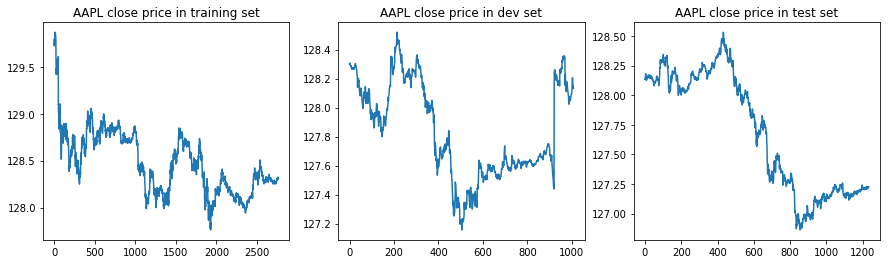

In [11]:
plot_training_dev_test('close','close price')

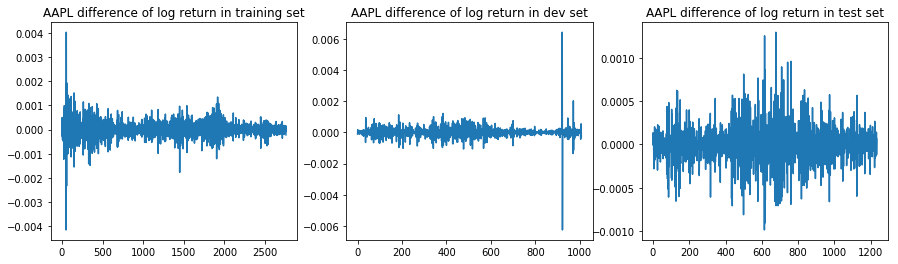

In [12]:
plot_training_dev_test('dlogret','difference of log return')

### 3.1.4 Set up models - ARIMA

ARIMA is a classifc model for forecasting a time series. Input data has to be made to be “stationary” by differencing (if necessary), perhaps in conjunction with nonlinear transformations such as logging or deflating (if necessary). 

A random variable that is a time series is stationary if its statistical properties are all constant over time.  A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense.  

ARIMA model includes AR specification, Integration order, and MA specification.

- AR: auto-regression on lagged Y value e.g. Y(t-1), Y(t-2)
- I:  difference of Y e.g. Y(t) - Y(t-1)
- MA: lagged error from previous period e.g. Y(t) - Yhat(t)


- Autocorrelation graph suggests MA terms to be 1
- Partical autocorrelation graph suggests AR terms to be 6.

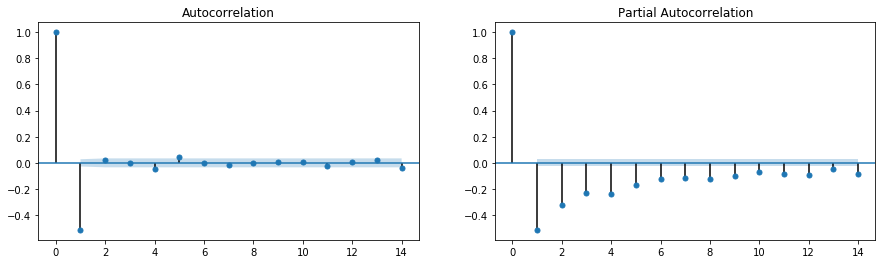

In [13]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(aapl.iloc[2:]['dlogret'], lags=14, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(aapl.iloc[2:]['dlogret'], lags=14, ax=axes[1])

You can playaround with your models with different AR/MA terms and see the performance in the development set. To get a satisfactory model, make sure you will select coeffificent with significant Z score ( greater than 1.96 or less than -1.96 for for 95% confidence level)

In the below model, all coefficient are statistically significant at 95% confidence level.

In [14]:
mod = sm.tsa.statespace.SARIMAX(training['logret'], order=(6,1,0))
fit_res = mod.fit(disp=False)
print(fit_res.summary())

                           Statespace Model Results                           
Dep. Variable:                 logret   No. Observations:                 2758
Model:               SARIMAX(6, 1, 0)   Log Likelihood               19172.290
Date:                Fri, 15 Jun 2018   AIC                         -38330.581
Time:                        08:15:48   BIC                         -38289.128
Sample:                             0   HQIC                        -38315.606
                               - 2758                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8586      0.005   -173.057      0.000      -0.868      -0.849
ar.L2         -0.7270      0.006   -130.053      0.000      -0.738      -0.716
ar.L3         -0.5871      0.004   -162.212      0.0

#### 3.1.5 one step forward prediction

use time t-1 actual information to predict return at time t

In [15]:
mod = sm.tsa.statespace.SARIMAX(aapl['logret'], order=(6,1,0))
res = mod.filter(fit_res.params)
predict = res.get_prediction()
predict_ci = predict.conf_int()

/home/nimish/.local/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [16]:
def plot_aapl_arima_forecast():
    # Graph
    fig, ax = plt.subplots(figsize=(15,4))
    npre = 4
    ax.set(title='AAPL log return', xlabel='Date', ylabel='log return')

    # Plot data points
    aapl.loc['2018-05-25 05:27:00':, 'logret'].plot(ax=ax, style='o', label='Observed')

    # Plot predictions
    predict.predicted_mean.loc['2018-05-25 05:27:00':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
    ci = predict_ci.loc['2018-05-25 05:27:00':]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    legend = ax.legend(loc='upper right')

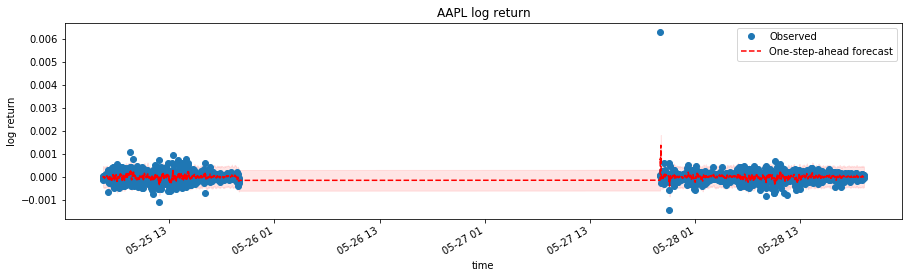

In [17]:
plot_aapl_arima_forecast()

## 3.2 Long Short Term Neural Network( LSTM)

<b>many-to-one LSTM</b>

- Input format: [samples, time steps, features]
- Output format: [sampels,target]

## 3.2.1 normalize input before feeding to a neural network

LSTMs are sensitive to the scale of the input data, due to back propagation through the time. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. Normalize can be easily done by using the MinMaxScaler preprocessing class from the scikit-learn library.

In [18]:
aapl.index

DatetimeIndex(['2018-05-23 06:38:00', '2018-05-23 06:39:00',
               '2018-05-23 06:40:00', '2018-05-23 06:41:00',
               '2018-05-23 06:42:00', '2018-05-23 06:43:00',
               '2018-05-23 06:44:00', '2018-05-23 06:45:00',
               '2018-05-23 06:46:00', '2018-05-23 06:47:00',
               ...
               '2018-05-28 20:05:00', '2018-05-28 20:06:00',
               '2018-05-28 20:07:00', '2018-05-28 20:08:00',
               '2018-05-28 20:10:00', '2018-05-28 20:11:00',
               '2018-05-28 20:12:00', '2018-05-28 20:13:00',
               '2018-05-28 20:14:00', '2018-05-28 20:15:00'],
              dtype='datetime64[ns]', name='time', length=5000, freq=None)

In [31]:
aapl.logret.fillna(0,inplace=True)
raw=aapl.close.values
scl = MinMaxScaler()
#Scale the data
raw= raw.reshape(raw.shape[0],1)
#plt.plot(raw)
#print (raw)
normalized = scaler.fit_transform(raw)
normalized

array([[0.97437604],
       [0.96306156],
       [0.95174709],
       ...,
       [0.121797  ],
       [0.11980033],
       [0.12046589]])

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

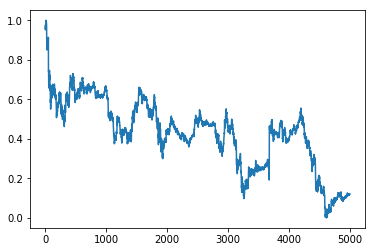

In [32]:
plt.plot(normalized);

## 3.2.2 Select Time Steps

Time steps - This is equivalent to the amount of time steps you run your recurrent neural network. If you want your network to have <b>memory</b> of 7 periods, this number should be 7.

In [33]:
def processData(data,time_step):
    X,Y = [],[]
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step),0])
        Y.append(data[(i+time_step),0])
    return np.array(X),np.array(Y)

In [34]:
NUM_TIME_STEPS = 7
NUM_FEATURES = 1
training_dev_split = 0.7

X,y = processData(normalized,NUM_TIME_STEPS)

X_train,X_dev = X[:int(X.shape[0]*training_dev_split)],X[int(X.shape[0]*training_dev_split):]
y_train,y_dev = y[:int(y.shape[0]*training_dev_split)],y[int(y.shape[0]*training_dev_split):]

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_dev = X_dev.reshape((X_dev.shape[0],X_dev.shape[1],1))

X_train.shape


(3494, 7, 1)

Let us have look at one sample data

- clearly time step is 7 meaning data is organized as [t-7,t-6,t-5,t-4,t-3,t-2,t-1]
- for each time step there is only one data point

In [35]:
X_train[0]

array([[0.97437604],
       [0.96306156],
       [0.95174709],
       [0.96206323],
       [0.96039933],
       [0.96139767],
       [0.97304493]])

In [36]:
y_train[0]

0.9670549084858493

## 3.2.2 Grid Search for number of neurons

In [37]:
# # Use scikit-learn to grid search the dropout rate


# Function to create model, 
def create_model(neurons=8,dropout_rate=0.0):
    
    model = Sequential()
    model.add(LSTM(neurons,input_shape=(NUM_TIME_STEPS,1)))
    #prevent overfitting
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasRegressor(build_fn=create_model, epochs=2,  verbose=1)
# define the grid search parameters
neurons = [8, 16, 24]
#weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.2, 0.3]

param_grid = dict(neurons=neurons,dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/2
2329/2329 [==============================] - 2s 1ms/step - loss: 0.0735
Epoch 2/2
2329/2329 [==============================] - 0s 54us/step
Epoch 1/2
2329/2329 [==============================] - 3s 1ms/step - loss: 0.1805
Epoch 2/2
2329/2329 [==============================] - 0s 50us/step
Epoch 1/2
2330/2330 [==============================] - 3s 1ms/step - loss: 0.1127
Epoch 2/2
2330/2330 [==============================] - 0s 63us/step
Epoch 1/2
2329/2329 [==============================] - 3s 1ms/step - loss: 0.0530
Epoch 2/2
2329/2329 [==============================] - 0s 52us/step
Epoch 1/2
2329/2329 [==============================] - 3s 1ms/step - loss: 0.1002
Epoch 2/2
2329/2329 [==============================] - 0s 59us/step
Epoch 1/2
2330/2330 [==============================] - 3s 1ms/step - loss: 0.0275
Epoch 2/2
2330/2330 [==============================] - 0s 57us/step
Epoch 1/2
2329/2329 [==============================] - 3s 1ms/step - loss: 0.0597
Epoch 2/2
2329/232

KeyboardInterrupt: 

## 3.2.3 Visualize Optimal Model with TensorBoard

In [26]:
import keras

model = Sequential()

model.add(LSTM(24,input_shape=(NUM_TIME_STEPS,1),return_sequences=True))
#prevent overfitting
model.add(Dropout(0.2))

model.add(LSTM(24,return_sequences=False))
# #prevent overfitting
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))

import time
start = time.time()

adam=keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
model.compile(loss='mse', optimizer=adam)
print ('compilation time : ', time.time() - start)

model.summary()

compilation time :  0.02677154541015625
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 7, 24)             2496      
_________________________________________________________________
dropout_20 (Dropout)         (None, 7, 24)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 24)                4704      
_________________________________________________________________
dropout_21 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 25        
Total params: 7,225
Trainable params: 7,225
Non-trainable params: 0
_________________________________________________________________


/home/nimish/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  del sys.path[0]


In [27]:
history = model.fit(X_train,y_train, epochs=500,validation_data=(X_dev,y_dev),shuffle=False)

Train on 3494 samples, validate on 1498 samples
Epoch 1/500
3494/3494 [==============================] - 5s 2ms/step - loss: 0.0260 - val_loss: 0.0148
Epoch 2/500
3494/3494 [==============================] - 2s 476us/step - loss: 0.0129 - val_loss: 0.0123
Epoch 3/500
3494/3494 [==============================] - 2s 504us/step - loss: 0.0100 - val_loss: 0.0067
Epoch 4/500
3494/3494 [==============================] - 2s 451us/step - loss: 0.0061 - val_loss: 0.0015
Epoch 5/500
3494/3494 [==============================] - 2s 456us/step - loss: 0.0031 - val_loss: 4.7392e-04
Epoch 6/500
3494/3494 [==============================] - 2s 452us/step - loss: 0.0021 - val_loss: 2.9091e-04
Epoch 7/500
3494/3494 [==============================] - 2s 449us/step - loss: 0.0017 - val_loss: 3.5821e-04
Epoch 8/500
3494/3494 [==============================] - 2s 457us/step - loss: 0.0016 - val_loss: 4.6502e-04
Epoch 9/500
3494/3494 [==============================] - 2s 449us/step - loss: 0.0014 - val_loss: 

3494/3494 [==============================] - 2s 463us/step - loss: 5.2182e-04 - val_loss: 2.8766e-04
Epoch 74/500
3494/3494 [==============================] - 2s 458us/step - loss: 5.2121e-04 - val_loss: 4.9312e-04
Epoch 75/500
3494/3494 [==============================] - 2s 450us/step - loss: 4.7528e-04 - val_loss: 3.5304e-04
Epoch 76/500
3494/3494 [==============================] - 2s 455us/step - loss: 6.4128e-04 - val_loss: 4.1203e-04
Epoch 77/500
3494/3494 [==============================] - 2s 455us/step - loss: 4.3700e-04 - val_loss: 3.1958e-04
Epoch 78/500
3494/3494 [==============================] - 2s 458us/step - loss: 5.1437e-04 - val_loss: 2.9091e-04
Epoch 79/500
3494/3494 [==============================] - 2s 450us/step - loss: 4.6874e-04 - val_loss: 2.9667e-04
Epoch 80/500
3494/3494 [==============================] - 2s 462us/step - loss: 5.1477e-04 - val_loss: 2.7405e-04
Epoch 81/500
3494/3494 [==============================] - 2s 454us/step - loss: 4.7313e-04 - val_loss

3494/3494 [==============================] - 2s 467us/step - loss: 4.4017e-04 - val_loss: 2.2621e-04
Epoch 145/500
3494/3494 [==============================] - 2s 496us/step - loss: 4.0739e-04 - val_loss: 2.2144e-04
Epoch 146/500
3494/3494 [==============================] - 2s 449us/step - loss: 3.7919e-04 - val_loss: 2.3110e-04
Epoch 147/500
3494/3494 [==============================] - 2s 446us/step - loss: 3.9614e-04 - val_loss: 2.1478e-04
Epoch 148/500
3494/3494 [==============================] - 2s 451us/step - loss: 3.9451e-04 - val_loss: 2.0130e-04
Epoch 149/500
3494/3494 [==============================] - 2s 482us/step - loss: 3.9393e-04 - val_loss: 2.1229e-04
Epoch 150/500
3494/3494 [==============================] - 2s 537us/step - loss: 3.9966e-04 - val_loss: 1.9698e-04
Epoch 151/500
3494/3494 [==============================] - 2s 498us/step - loss: 4.0299e-04 - val_loss: 2.2674e-04
Epoch 152/500
3494/3494 [==============================] - 2s 467us/step - loss: 3.7580e-04 - 

3494/3494 [==============================] - 2s 449us/step - loss: 3.5548e-04 - val_loss: 1.6327e-04
Epoch 216/500
3494/3494 [==============================] - 1s 429us/step - loss: 3.6019e-04 - val_loss: 1.6220e-04
Epoch 217/500
3494/3494 [==============================] - 2s 439us/step - loss: 3.7870e-04 - val_loss: 1.6411e-04
Epoch 218/500
3494/3494 [==============================] - 2s 440us/step - loss: 3.5340e-04 - val_loss: 1.7241e-04
Epoch 219/500
3494/3494 [==============================] - 2s 446us/step - loss: 3.7562e-04 - val_loss: 1.8083e-04
Epoch 220/500
3494/3494 [==============================] - 2s 443us/step - loss: 3.5677e-04 - val_loss: 1.7636e-04
Epoch 221/500
3494/3494 [==============================] - 2s 443us/step - loss: 3.4948e-04 - val_loss: 1.8205e-04
Epoch 222/500
3494/3494 [==============================] - 2s 454us/step - loss: 3.7071e-04 - val_loss: 1.6407e-04
Epoch 223/500
3494/3494 [==============================] - 2s 450us/step - loss: 3.5491e-04 - 

3494/3494 [==============================] - 1s 348us/step - loss: 3.3604e-04 - val_loss: 1.4027e-04
Epoch 287/500
3494/3494 [==============================] - 1s 350us/step - loss: 3.6182e-04 - val_loss: 1.5491e-04
Epoch 288/500
3494/3494 [==============================] - 1s 348us/step - loss: 3.6453e-04 - val_loss: 1.5284e-04
Epoch 289/500
3494/3494 [==============================] - 1s 349us/step - loss: 3.7025e-04 - val_loss: 1.4384e-04
Epoch 290/500
3494/3494 [==============================] - 1s 350us/step - loss: 3.8459e-04 - val_loss: 1.5693e-04
Epoch 291/500
3494/3494 [==============================] - 1s 353us/step - loss: 3.7898e-04 - val_loss: 1.5649e-04
Epoch 292/500
3494/3494 [==============================] - 1s 360us/step - loss: 3.4830e-04 - val_loss: 1.3903e-04
Epoch 293/500
3494/3494 [==============================] - 1s 366us/step - loss: 3.6006e-04 - val_loss: 1.4355e-04
Epoch 294/500
3494/3494 [==============================] - 2s 506us/step - loss: 3.5954e-04 - 

3494/3494 [==============================] - 1s 365us/step - loss: 3.4021e-04 - val_loss: 1.2708e-04
Epoch 358/500
3494/3494 [==============================] - 1s 367us/step - loss: 3.4007e-04 - val_loss: 1.3716e-04
Epoch 359/500
3494/3494 [==============================] - 1s 377us/step - loss: 3.4456e-04 - val_loss: 1.3805e-04
Epoch 360/500
3494/3494 [==============================] - 2s 501us/step - loss: 3.4143e-04 - val_loss: 1.4320e-04
Epoch 361/500
3494/3494 [==============================] - 1s 374us/step - loss: 3.2736e-04 - val_loss: 1.2094e-04
Epoch 362/500
3494/3494 [==============================] - 1s 352us/step - loss: 3.3099e-04 - val_loss: 1.3301e-04
Epoch 363/500
3494/3494 [==============================] - 1s 358us/step - loss: 3.5005e-04 - val_loss: 1.2607e-04
Epoch 364/500
3494/3494 [==============================] - 1s 368us/step - loss: 3.4249e-04 - val_loss: 1.3381e-04
Epoch 365/500
3494/3494 [==============================] - 1s 389us/step - loss: 3.3724e-04 - 

3494/3494 [==============================] - 1s 399us/step - loss: 3.5292e-04 - val_loss: 1.3339e-04
Epoch 429/500
3494/3494 [==============================] - 1s 372us/step - loss: 3.2352e-04 - val_loss: 1.2850e-04
Epoch 430/500
3494/3494 [==============================] - 1s 405us/step - loss: 3.3765e-04 - val_loss: 1.2864e-04
Epoch 431/500
3494/3494 [==============================] - 1s 386us/step - loss: 3.4814e-04 - val_loss: 1.3107e-04
Epoch 432/500
3494/3494 [==============================] - 1s 386us/step - loss: 3.2243e-04 - val_loss: 1.2974e-04
Epoch 433/500
3494/3494 [==============================] - 1s 373us/step - loss: 3.2741e-04 - val_loss: 1.2515e-04
Epoch 434/500
3494/3494 [==============================] - 1s 384us/step - loss: 3.4704e-04 - val_loss: 1.2425e-04
Epoch 435/500
3494/3494 [==============================] - 1s 417us/step - loss: 3.3093e-04 - val_loss: 1.2577e-04
Epoch 436/500
3494/3494 [==============================] - 1s 415us/step - loss: 3.2589e-04 - 

3494/3494 [==============================] - 1s 369us/step - loss: 3.4063e-04 - val_loss: 1.2603e-04
Epoch 500/500
3494/3494 [==============================] - 1s 391us/step - loss: 3.6833e-04 - val_loss: 1.2426e-04


create a folder with the name 'graph_logret'

Now open a terminal and put

tensorboard --logdir=''../graph_logret'

Your tensorboard will be launched at the default port (6006)

In [28]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='../graph_logret', histogram_freq=10, write_graph=True, write_images=True)

history = model.fit(X_train,y_train,epochs=500,validation_data=(X_dev,y_dev),shuffle=False,callbacks=[tbCallBack])

Train on 3494 samples, validate on 1498 samples
Epoch 1/500
3494/3494 [==============================] - 1s 368us/step - loss: 3.3854e-04 - val_loss: 1.0916e-04
Epoch 2/500
3494/3494 [==============================] - 1s 380us/step - loss: 3.1326e-04 - val_loss: 1.1104e-04
Epoch 3/500
3494/3494 [==============================] - 1s 399us/step - loss: 3.4600e-04 - val_loss: 1.1643e-04
Epoch 4/500
3494/3494 [==============================] - 1s 378us/step - loss: 3.2438e-04 - val_loss: 1.2094e-04
Epoch 5/500
3494/3494 [==============================] - 1s 376us/step - loss: 3.4115e-04 - val_loss: 1.1808e-04
Epoch 6/500
3494/3494 [==============================] - 1s 404us/step - loss: 3.3212e-04 - val_loss: 1.1780e-04
Epoch 7/500
3494/3494 [==============================] - 1s 385us/step - loss: 3.1274e-04 - val_loss: 1.4405e-04
Epoch 8/500
3494/3494 [==============================] - 1s 371us/step - loss: 3.4032e-04 - val_loss: 1.3146e-04
Epoch 9/500
3494/3494 [=========================

3494/3494 [==============================] - 1s 365us/step - loss: 3.4905e-04 - val_loss: 1.1224e-04
Epoch 73/500
3494/3494 [==============================] - 1s 363us/step - loss: 3.3860e-04 - val_loss: 1.1925e-04
Epoch 74/500
3494/3494 [==============================] - 1s 365us/step - loss: 3.2365e-04 - val_loss: 1.1755e-04
Epoch 75/500
3494/3494 [==============================] - 1s 360us/step - loss: 3.3250e-04 - val_loss: 1.1422e-04
Epoch 76/500
3494/3494 [==============================] - 1s 372us/step - loss: 3.4371e-04 - val_loss: 1.2390e-04
Epoch 77/500
3494/3494 [==============================] - 1s 361us/step - loss: 3.2379e-04 - val_loss: 1.1782e-04
Epoch 78/500
3494/3494 [==============================] - 1s 367us/step - loss: 3.4196e-04 - val_loss: 1.0913e-04
Epoch 79/500
3494/3494 [==============================] - 1s 365us/step - loss: 3.2414e-04 - val_loss: 1.1227e-04
Epoch 80/500
3494/3494 [==============================] - 1s 368us/step - loss: 3.3945e-04 - val_loss

3494/3494 [==============================] - 1s 385us/step - loss: 3.3440e-04 - val_loss: 1.0653e-04
Epoch 144/500
3494/3494 [==============================] - 1s 381us/step - loss: 3.3825e-04 - val_loss: 1.0348e-04
Epoch 145/500
3494/3494 [==============================] - 1s 392us/step - loss: 3.3219e-04 - val_loss: 1.2841e-04
Epoch 146/500
3494/3494 [==============================] - 1s 388us/step - loss: 3.2390e-04 - val_loss: 1.0676e-04
Epoch 147/500
3494/3494 [==============================] - 1s 397us/step - loss: 3.2180e-04 - val_loss: 1.0750e-04
Epoch 148/500
3494/3494 [==============================] - 2s 438us/step - loss: 3.4938e-04 - val_loss: 1.4315e-04
Epoch 149/500
3494/3494 [==============================] - 1s 397us/step - loss: 3.5051e-04 - val_loss: 1.1637e-04
Epoch 150/500
3494/3494 [==============================] - 1s 383us/step - loss: 3.3050e-04 - val_loss: 1.1114e-04
Epoch 151/500
3494/3494 [==============================] - 1s 373us/step - loss: 3.3890e-04 - 

3494/3494 [==============================] - 1s 377us/step - loss: 3.1202e-04 - val_loss: 1.1056e-04
Epoch 215/500
3494/3494 [==============================] - 1s 377us/step - loss: 3.3224e-04 - val_loss: 1.0253e-04
Epoch 216/500
3494/3494 [==============================] - 2s 596us/step - loss: 3.3581e-04 - val_loss: 1.0543e-04
Epoch 217/500
3494/3494 [==============================] - 1s 371us/step - loss: 3.3261e-04 - val_loss: 1.3902e-04
Epoch 218/500
3494/3494 [==============================] - 1s 359us/step - loss: 3.1938e-04 - val_loss: 1.0883e-04
Epoch 219/500
3494/3494 [==============================] - 1s 370us/step - loss: 3.2127e-04 - val_loss: 1.1671e-04
Epoch 220/500
3494/3494 [==============================] - 1s 360us/step - loss: 3.4192e-04 - val_loss: 1.0495e-04
Epoch 221/500
3494/3494 [==============================] - 1s 367us/step - loss: 3.4388e-04 - val_loss: 1.0668e-04
Epoch 222/500
3494/3494 [==============================] - 1s 369us/step - loss: 3.4926e-04 - 

3494/3494 [==============================] - 1s 371us/step - loss: 3.2898e-04 - val_loss: 1.1299e-04
Epoch 286/500
3494/3494 [==============================] - 1s 385us/step - loss: 3.2040e-04 - val_loss: 1.2882e-04
Epoch 287/500
3494/3494 [==============================] - 1s 376us/step - loss: 3.4035e-04 - val_loss: 1.0556e-04
Epoch 288/500
3494/3494 [==============================] - 1s 365us/step - loss: 3.5190e-04 - val_loss: 1.1035e-04
Epoch 289/500
3494/3494 [==============================] - 1s 364us/step - loss: 3.3012e-04 - val_loss: 1.0985e-04
Epoch 290/500
3494/3494 [==============================] - 1s 363us/step - loss: 3.2308e-04 - val_loss: 1.0822e-04
Epoch 291/500
3494/3494 [==============================] - 1s 370us/step - loss: 3.4422e-04 - val_loss: 1.2732e-04
Epoch 292/500
3494/3494 [==============================] - 1s 390us/step - loss: 3.3231e-04 - val_loss: 1.1333e-04
Epoch 293/500
3494/3494 [==============================] - 1s 393us/step - loss: 3.2168e-04 - 

3494/3494 [==============================] - 1s 391us/step - loss: 3.2807e-04 - val_loss: 1.0617e-04
Epoch 357/500
3494/3494 [==============================] - 1s 390us/step - loss: 3.3185e-04 - val_loss: 1.2287e-04
Epoch 358/500
3494/3494 [==============================] - 1s 394us/step - loss: 3.3113e-04 - val_loss: 1.2048e-04
Epoch 359/500
3494/3494 [==============================] - 1s 390us/step - loss: 3.2997e-04 - val_loss: 1.1131e-04
Epoch 360/500
3494/3494 [==============================] - 1s 374us/step - loss: 3.3171e-04 - val_loss: 1.0429e-04
Epoch 361/500
3494/3494 [==============================] - 1s 375us/step - loss: 3.1306e-04 - val_loss: 1.2827e-04
Epoch 362/500
3494/3494 [==============================] - 1s 378us/step - loss: 3.1435e-04 - val_loss: 1.3357e-04
Epoch 363/500
3494/3494 [==============================] - 1s 382us/step - loss: 3.2468e-04 - val_loss: 1.3708e-04
Epoch 364/500
3494/3494 [==============================] - 1s 382us/step - loss: 3.3643e-04 - 

3494/3494 [==============================] - 1s 365us/step - loss: 3.3692e-04 - val_loss: 1.0392e-04
Epoch 428/500
3494/3494 [==============================] - 1s 364us/step - loss: 3.2920e-04 - val_loss: 1.0696e-04
Epoch 429/500
3494/3494 [==============================] - 1s 362us/step - loss: 3.3399e-04 - val_loss: 1.2514e-04
Epoch 430/500
3494/3494 [==============================] - 1s 361us/step - loss: 3.4017e-04 - val_loss: 1.5171e-04
Epoch 431/500
3494/3494 [==============================] - 1s 363us/step - loss: 3.4293e-04 - val_loss: 1.1281e-04
Epoch 432/500
3494/3494 [==============================] - 1s 367us/step - loss: 3.2155e-04 - val_loss: 1.2837e-04
Epoch 433/500
3494/3494 [==============================] - 1s 370us/step - loss: 3.2367e-04 - val_loss: 1.1446e-04
Epoch 434/500
3494/3494 [==============================] - 1s 362us/step - loss: 3.1042e-04 - val_loss: 1.2579e-04
Epoch 435/500
3494/3494 [==============================] - 1s 372us/step - loss: 3.4179e-04 - 

3494/3494 [==============================] - 2s 577us/step - loss: 3.2882e-04 - val_loss: 1.0720e-04
Epoch 499/500
3494/3494 [==============================] - 1s 369us/step - loss: 3.0830e-04 - val_loss: 1.0844e-04
Epoch 500/500
3494/3494 [==============================] - 1s 374us/step - loss: 3.2313e-04 - val_loss: 1.0729e-04


One may ask a querstion. Why my validation loss is less than training loss?

I got the answer from Keras FAQ.


<b>Why is the training loss much higher than the testing loss?</b>

A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.

Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

reference: https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss

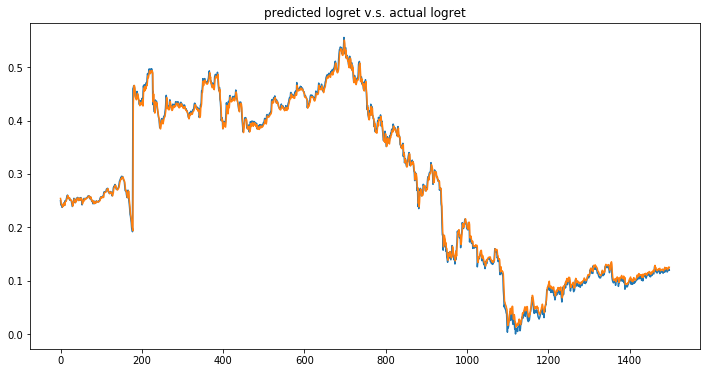

In [29]:
Xt = model.predict(X_dev)
plt.figure(figsize=(12,6))
plt.plot(y_dev.reshape(-1,1))
plt.plot(Xt);
plt.title('predicted logret v.s. actual logret');

Please note the predicted value is sometime above and sometimes below actual value. It means you 
got positive error and negative error which is normal. If you see your predictions keep below or above
actual value, that indicates the model has systematic error. You can try use close price instead of
log returns as input and draw a comparison between prediction and actual value. Check whether you will 
have systematic error.

In [ ]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_dev)

# invert predictions
trainPredict = scl.inverse_transform(trainPredict)
trainY = scl.inverse_transform([y_train])
testPredict = scl.inverse_transform(testPredict)
testY = scl.inverse_transform([y_dev])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(y_dev, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore));

print (testY)
print (trainY)

## 3.2.4 sequence forecast

We will need the TimeDistributed layer here. The TimeDistrubuted lay makes sure the model will be applied to each time step. Therefore, we will get a sequence with the number of ouput matches to number of time steps.

- In this case, the output will be 3D. This means that if your TimeDistributed wrapped Dense layer is your output layer and you are predicting a sequence, you will need to resize your y array into a 3D vector.

In [38]:
NUM_TIME_STEPS = 7

def processSequence(data,time_steps):
    X,Y = [],[]
    for i in range(len(data)-2*time_steps-1):
        X.append(data[i:(i+time_steps),0])
        Y.append(data[(i+time_steps):(i+2*time_steps),0])
    return np.array(X),np.array(Y)


X,y = processSequence(raw,NUM_TIME_STEPS)

X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

print(X_train.shape)
print(y_train.shape)

(3988, 7)
(3988, 7)


In [39]:
X_train[0]

array([129.79 , 129.756, 129.722, 129.753, 129.748, 129.751, 129.786])

In [40]:
y_train[1]

array([129.788, 129.797, 129.842, 129.867, 129.832, 129.844, 129.848])

In [41]:
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
y_train = X_train.reshape((y_train.shape[0],y_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

y_train.shape

(3988, 7, 1)

In [42]:
from keras.layers import TimeDistributed
import keras

model = Sequential()

model.add(LSTM(8,input_shape=(NUM_TIME_STEPS,1),return_sequences=True))
#prevent overfitting
model.add(Dropout(0.2))

model.add(LSTM(8,return_sequences=True))
#prevent overfitting
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(1)))
model.add(Activation('linear'))

import time
start = time.time()

adam=keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
model.compile(loss='mse', optimizer=adam)
print ('compilation time : ', time.time() - start)

model.summary()

compilation time :  0.024903059005737305
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 7, 8)              320       
_________________________________________________________________
dropout_29 (Dropout)         (None, 7, 8)              0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 7, 8)              544       
_________________________________________________________________
dropout_30 (Dropout)         (None, 7, 8)              0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              9         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 1)              0         
Total params: 873
Trainable params: 873
Non-trainable params: 0
_____________________________________

In [43]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),shuffle=False)

Train on 3988 samples, validate on 997 samples
Epoch 1/20
3988/3988 [==============================] - 5s 1ms/step - loss: 15334.6760 - val_loss: 14047.5519
Epoch 2/20
3988/3988 [==============================] - 1s 291us/step - loss: 13566.5596 - val_loss: 12767.5961
Epoch 3/20
3988/3988 [==============================] - 1s 343us/step - loss: 12428.2699 - val_loss: 11741.2220
Epoch 4/20
3988/3988 [==============================] - 1s 355us/step - loss: 11510.9684 - val_loss: 10906.6012
Epoch 5/20
3988/3988 [==============================] - 1s 339us/step - loss: 10743.0922 - val_loss: 10202.5727
Epoch 6/20
3988/3988 [==============================] - 1s 291us/step - loss: 10073.2917 - val_loss: 9587.1117
Epoch 7/20
3988/3988 [==============================] - 1s 298us/step - loss: 9485.5362 - val_loss: 9041.7674
Epoch 8/20
3988/3988 [==============================] - 1s 290us/step - loss: 8968.9391 - val_loss: 8554.0661
Epoch 9/20
3988/3988 [==============================] - 1s 290us

In [44]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		y_true = np.array([row[i] for row in test])
		y_pred = np.array([forecast[i] for forecast in forecasts])
		mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
		rmse=sqrt(mean_squared_error(y_true,y_pred))
		print('t+%d MAPE: %f' % ((i+1), mape))
		print('t+%d RMSE: %f' % ((i+1), rmse))  

In [45]:
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [46]:
#INVERT TRANSFORMED TO ACTUAL FORM
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]

		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index][1]
		
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

t+1 MAPE: 38.397531
t+1 RMSE: 244.923150


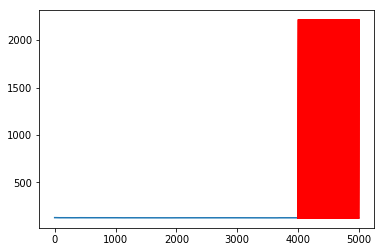

In [47]:
#not considering validationdata,might add on later
from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

filename='EUR_JPY.csv'
series=pd.read_csv(filename)
forecasts = model.predict(X_test)
#scaling and inverse helper function
forecasts = inverse_transform(series, forecasts, scaler,1000)
#actual data to compare results with
actual = y_test
actual = inverse_transform(series, actual, scaler, 1000)
evaluate_forecasts(actual, forecasts, 2,1)
#print (series.close.values,forecasts[:5])
series=series.close
plot_forecasts(series, forecasts, 1000)

## 4 Utilize pre-trained models

Where can we find Pre-trained Networks?
It depends on the deep learning framework. For popular frameworks like Caffe, Keras, TensorFlow, Torch, MxNet, etc, their respective contributors usually keep a list of the state-of-the-art Covnet models (VGG, Inception, ResNet, etc) with their implementations and pre-trained weights on a common dataset like the ImageNet or CIFAR.


- Caffe
Model Zoo - A platform for third party contributors to share pre-trained caffe models
 
- Keras
Keras Application - Implementation of popular state-of-the-art Convnet models like VGG16/19, googleNetNet, Inception V3, and ResNet
 
- TensorFlow
VGG16
Inception V3
ResNet
 
- Torch
LoadCaffe - Maintains a list of popular models like AlexNet and VGG .Weights ported from Caffe
 
- MxNet
MxNet Model Gallery - Maintains pre-trained Inception-BN (V2) and Inception V3.


To fine-tune pretrined model, we truncate the original softmax layer and replace it with our own by the following snippet:


Sometimes, we want to freeze the weight for the first few layers so that they remain intact throughout the fine-tuning process. Say we want to freeze the weights for the first 10 layers. This can be done by the following lines:


We then fine-tune the model by minimizing the cross entropy loss function using stochastic gradient descent (sgd) algorithm. Notice that we use an initial learning rate of 0.001, which is smaller than the learning rate for training scratch model (usually 0.01).